<a href="https://colab.research.google.com/github/weswest/MSDS422/blob/main/MSDS_422_Assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Project Overview

This workbook focuses on the Cats Dogs Redux...

https://www.kaggle.com/alpaca0984/dogs-vs-cats-tensorflow-2-0-on-google-colab

# Workbook Structure

TKTKTK

## Considerations for analysis vs EDA

TKTKTK



## Overall layout

TKTKTK


# 0 Setup


## 0.1 Setup - Load Libraries

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import pathlib
import warnings
warnings.filterwarnings('ignore')

import os
import io

pd.set_option('display.max_columns', None)

In [2]:
#from kerastuner.tuners import RandomSearch

def set_seed(seed=422):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## 0.2 Setup - Operating Environment
This code allows the Colab notebook to access my Google Drive files.  Also sets up Kaggle API if it doesn't exist yet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

kaggle_api = pd.read_json("drive/My Drive/APIs/kaggle.json", typ='dictionary')

try:
  os.chdir("drive/My Drive/MSDS/422/DogsCatsRedux")
except:
  pass

Mounted at /content/drive


In [4]:
# Look at this notebook for instructions on loading in the data:
# https://www.kaggle.com/alpaca0984/dogs-vs-cats-tensorflow-2-0-on-google-colab

file_setup = False

if file_setup == True:
  os.environ['KAGGLE_USERNAME'] = kaggle_api['username'] # username from the json file
  os.environ['KAGGLE_KEY'] = kaggle_api['key'] # key from the json file
  !kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
  !unzip 'test.zip'
  !unzip 'train.zip'
  
  !mkdir train/{dog,cat}
  !find train -maxdepth 1 -type f | grep 'dog' | xargs -I{} mv {} train/dog
  !find train -maxdepth 1 -type f | grep 'cat' | xargs -I{} mv {} train/cat
  
  !mkdir test/images
  !find test -maxdepth 1 -type f | xargs -I{} mv {} test/images



## 0.3 Setup - Read in Data


In [5]:
train_dir = './train'
train_dog_dir = './train/dog'
train_cat_dir = './train/cat'
total_train = len(os.listdir('./train/dog')) + len(os.listdir('./train/cat'))
total_test = len(os.listdir('./test/images/'))
validation_split = 0.2

batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [6]:
print(total_train, total_test)

25000 12500


In [7]:
train_cat_fnames = os.listdir(train_cat_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dog_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.9100.jpg', 'cat.9085.jpg', 'cat.9121.jpg', 'cat.9106.jpg', 'cat.9114.jpg', 'cat.9078.jpg', 'cat.9081.jpg', 'cat.9073.jpg', 'cat.9079.jpg', 'cat.9119.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg', 'dog.10000.jpg', 'dog.10001.jpg', 'dog.10002.jpg', 'dog.10003.jpg', 'dog.10004.jpg']


## 0.4 Set up functions for later reference



# 1 EDA

Source of code: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=C3WZABE9eX-8

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

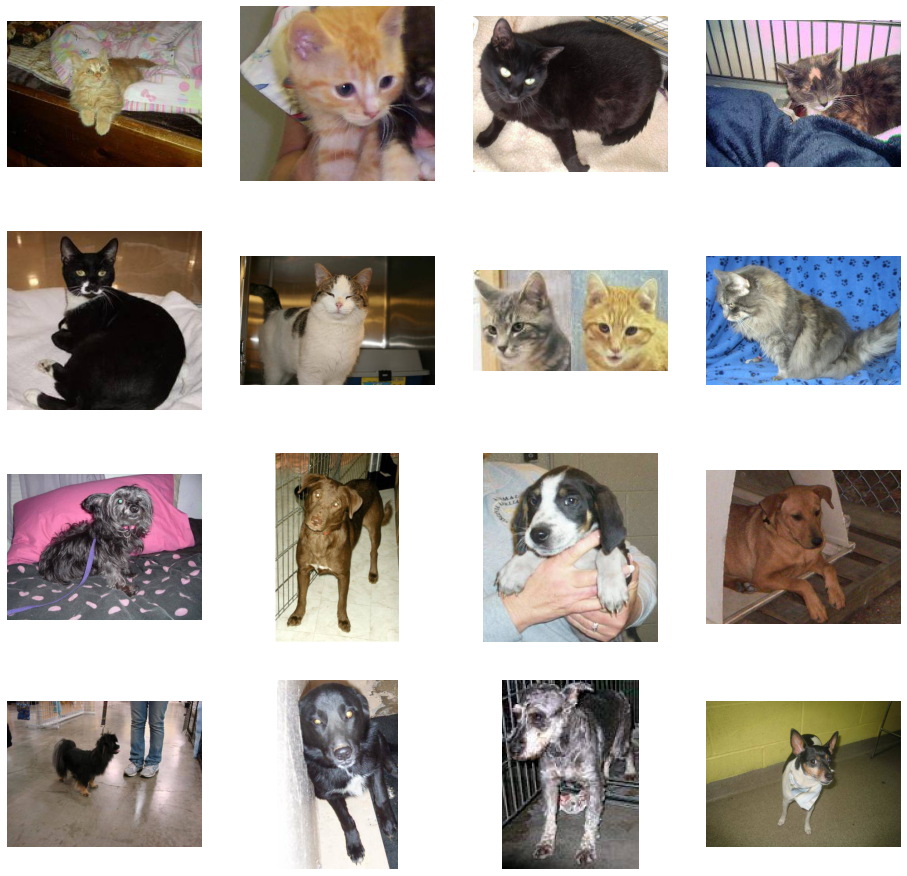

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cat_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dog_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# 2. Build Neural Networks

In [10]:
Model1_exist = True
Model2_exist = True
Model3_exist = True

## 2.0 Build the Neural Network Data

In [11]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           validation_split=validation_split)
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           subset='training')
val_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           subset='validation')



Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## 2.1 Build Neural Network Model 1

In [12]:
model1 = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same', activation='relu'),
#    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same', activation='relu'),
#    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [13]:
Model1_interim = False

if Model1_exist == False:

  model1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Wk8Model1.h5", save_best_only=True)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

  if Model1_interim == True:
      model1 = load_model('Wk8Model1.h5')
      initial_epoch = 4

  history = model1.fit(
      train_data_gen,
      epochs=epochs,
      validation_data=val_data_gen,
      steps_per_epoch=(total_train * (1 - validation_split) // batch_size),
      validation_steps=(total_train * validation_split // batch_size),
      callbacks=[checkpoint_cb, early_stopping_cb],
      initial_epoch = initial_epoch
  )

  #model1.save('Wk8Model1')   # Commented out so that a run doesn't overwrite the model


In [14]:
if Model1_exist == False:
  # Displaying CV metrics
  hist_df = pd.DataFrame(history.history)
  
  fig,axes=plt.subplots(1,2,figsize=(20,6))
  sns.lineplot(data=hist_df[['loss','val_loss']], dashes=False, ax=axes[0])
  axes[0].axhline(0.05, ls='--')
  axes[0].axhline(0, ls='--')
  sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
  axes[1].axhline(0.99, ls='--')
  axes[1].axhline(0.995, ls='--')
  axes[1].axhline(0.996, ls='--')
  axes[1].axhline(0.997, ls='--')
  axes[1].axhline(0.998, ls='--')
  axes[1].axhline(1, ls='--')
  plt.show()

## 2.2 Build Neural Network Model 2

In [15]:
## Define your model with the structure you want to use

model2 = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                  

In [16]:
Model2_interim = True # This is a placeholder trigger.  If true then the code later on will load an existing model

if Model2_exist == False: # This is a separate trigger defined elsewhere.  If Model2 is already built, skip building it

  model2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# These are callback declarations.  Callbacks will run at the end of each epoch

# The ModelCheckpoint will save the structure of the model in the filename given
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Wk8Model2Interim.h5", save_best_only=True)

# The EarlyStopping will early stop the model.
# Patience = 2 means that the model will stop if validation loss fails to descend for 2 epochs

  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

  if Model2_interim == True:
    # The following line of code overwrites the model2 defined above.  Note: structure will be maintained
      model2 = load_model('Wk8Model2Interim.h5')  # Note the file name is the same as above
      initial_epoch = 5

  history = model2.fit(
      train_data_gen,
      epochs=epochs,
      validation_data=val_data_gen,
      steps_per_epoch=(total_train * (1 - validation_split) // batch_size),
      validation_steps=(total_train * validation_split // batch_size),
      callbacks=[checkpoint_cb, early_stopping_cb], # This line needs to be added to trigger the callbacks
      initial_epoch = initial_epoch
  )

# This code down here saves the entire model structure as a folder.
# My own fear of lost work means that I save this as a slightly different filename than the interim files above
  model2.save('Wk8Model2')   # Comment this out after the model runs so that a run doesn't accidentally overwrite the model


### 2.2.1 FYI results for a model attempt

Epoch 1/10
156/156 [==============================] - 3157s 20s/step - loss: 0.6913 - accuracy: 0.5181 - val_loss: 0.6802 - val_accuracy: 0.5833
Epoch 2/10
156/156 [==============================] - 3144s 20s/step - loss: 0.6677 - accuracy: 0.5858 - val_loss: 0.6774 - val_accuracy: 0.5845
Epoch 3/10
156/156 [==============================] - 3052s 20s/step - loss: 0.6589 - accuracy: 0.6125 - val_loss: 0.6186 - val_accuracy: 0.6508
Epoch 4/10
156/156 [==============================] - 3030s 19s/step - loss: 0.5871 - accuracy: 0.6937 - val_loss: 0.5306 - val_accuracy: 0.7354
Epoch 5/10
156/156 [==============================] - 3059s 20s/step - loss: 0.5256 - accuracy: 0.7367 - val_loss: 0.4874 - val_accuracy: 0.7600
Epoch 6/10
156/156 [==============================] - 5679s 35s/step - loss: 0.4625 - accuracy: 0.7833 - val_loss: 0.4534 - val_accuracy: 0.7879
Epoch 7/10
156/156 [==============================] - 3121s 20s/step - loss: 0.3998 - accuracy: 0.8180 - val_loss: 0.4431 - val_accuracy: 0.7909
Epoch 8/10
156/156 [==============================] - 3073s 20s/step - loss: 0.3368 - accuracy: 0.8559 - val_loss: 0.4200 - val_accuracy: 0.8089
Epoch 9/10
156/156 [==============================] - 3068s 20s/step - loss: 0.2730 - accuracy: 0.8885 - val_loss: 0.4167 - val_accuracy: 0.8201
Epoch 10/10
156/156 [==============================] - 3066s 20s/step - loss: 0.2042 - accuracy: 0.9180 - val_loss: 0.4545 - val_accuracy: 0.8205

In [17]:
if Model2_exist == False:
  # Displaying CV metrics
  hist_df = pd.DataFrame(history.history)
  
  fig,axes=plt.subplots(1,2,figsize=(20,6))
  sns.lineplot(data=hist_df[['loss','val_loss']], dashes=False, ax=axes[0])
  axes[0].axhline(0.05, ls='--')
  axes[0].axhline(0, ls='--')
  sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
  axes[1].axhline(0.99, ls='--')
  axes[1].axhline(0.995, ls='--')
  axes[1].axhline(0.996, ls='--')
  axes[1].axhline(0.997, ls='--')
  axes[1].axhline(0.998, ls='--')
  axes[1].axhline(1, ls='--')
  plt.show()

## 2.3 Build Neural Network Model 3

In [18]:
## Define your model with the structure you want to use

model3 = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same', activation='relu'),
#    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same', activation='relu'),
#    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Flatten(),
#    Dense(256, activation='relu'),
#    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 18, 18, 128)     

In [19]:
Model3_interim = False # This is a placeholder trigger.  If true then the code later on will load an existing model

if Model3_exist == False: # This is a separate trigger defined elsewhere.  If Model2 is already built, skip building it

  model3.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# These are callback declarations.  Callbacks will run at the end of each epoch

# The ModelCheckpoint will save the structure of the model in the filename given
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Wk8Model3Interim.h5", save_best_only=True)

# The EarlyStopping will early stop the model.
# Patience = 2 means that the model will stop if validation loss fails to descend for 2 epochs

  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

  if Model3_interim == True:
    # The following line of code overwrites the model2 defined above.  Note: structure will be maintained
      model3 = load_model('Wk8Model3Interim.h5')  # Note the file name is the same as above
      initial_epoch = 5

  history = model3.fit(
      train_data_gen,
      epochs=epochs,
      validation_data=val_data_gen,
      steps_per_epoch=(total_train * (1 - validation_split) // batch_size),
      validation_steps=(total_train * validation_split // batch_size),
      callbacks=[checkpoint_cb, early_stopping_cb] # This line needs to be added to trigger the callbacks
 #     initial_epoch = initial_epoch
  )

# This code down here saves the entire model structure as a folder.
# My own fear of lost work means that I save this as a slightly different filename than the interim files above
  model3.save('Wk8Model3')   # Comment this out after the model runs so that a run doesn't accidentally overwrite the model


Epoch 1/10
156/156 [==============================] - 1032s 7s/step - loss: 0.6391 - accuracy: 0.6402 - val_loss: 0.5551 - val_accuracy: 0.7196
Epoch 2/10
156/156 [==============================] - 1032s 7s/step - loss: 0.5182 - accuracy: 0.7432 - val_loss: 0.4770 - val_accuracy: 0.7724
Epoch 3/10
156/156 [==============================] - 1033s 7s/step - loss: 0.4768 - accuracy: 0.7719 - val_loss: 0.4506 - val_accuracy: 0.7941
Epoch 4/10
156/156 [==============================] - 1032s 7s/step - loss: 0.4126 - accuracy: 0.8122 - val_loss: 0.4182 - val_accuracy: 0.8087
Epoch 5/10
156/156 [==============================] - 1029s 7s/step - loss: 0.3624 - accuracy: 0.8402 - val_loss: 0.3938 - val_accuracy: 0.8205
Epoch 6/10
156/156 [==============================] - 1020s 7s/step - loss: 0.3175 - accuracy: 0.8617 - val_loss: 0.3780 - val_accuracy: 0.8353
Epoch 7/10
156/156 [==============================] - 1034s 7s/step - loss: 0.2683 - accuracy: 0.8881 - val_loss: 0.3759 - val_accuracy: 0.8363
Epoch 8/10
156/156 [==============================] - 1040s 7s/step - loss: 0.2283 - accuracy: 0.9063 - val_loss: 0.4037 - val_accuracy: 0.8343
Epoch 9/10
156/156 [==============================] - 1035s 7s/step - loss: 0.1820 - accuracy: 0.9294 - val_loss: 0.3929 - val_accuracy: 0.8403
INFO:tensorflow:Assets written to: Wk8Model3/assets

In [20]:
if Model3_exist == False:
  # Displaying CV metrics
  hist_df = pd.DataFrame(history.history)
  
  fig,axes=plt.subplots(1,2,figsize=(20,6))
  sns.lineplot(data=hist_df[['loss','val_loss']], dashes=False, ax=axes[0])
  axes[0].axhline(0.05, ls='--')
  axes[0].axhline(0, ls='--')
  sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
  axes[1].axhline(0.99, ls='--')
  axes[1].axhline(0.995, ls='--')
  axes[1].axhline(0.996, ls='--')
  axes[1].axhline(0.997, ls='--')
  axes[1].axhline(0.998, ls='--')
  axes[1].axhline(1, ls='--')
  plt.show()

# 4. Submit Models

## 4.1 Build test dataset

In [21]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory='./test/',
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           shuffle=False,
                                                           class_mode=None,
                                                           batch_size=1)

Found 12500 images belonging to 1 classes.


## 4.2 Reload models

In [23]:
model1 = load_model('Wk8Model1')
model2 = load_model('Wk8Model2')
model3 = load_model('Wk8Model3')


## 4.3 Build Predictions

In [44]:
predictions1_exist = True
predictions2_exist = False
predictions3_exist = False


### 4.3.1 Build Model1 Predictions

In [45]:
if predictions1_exist == False:

  test_data_gen.reset()
  predictions1 = model1.predict(test_data_gen, steps=total_test, verbose=1)
  pred1_df = pd.DataFrame(np.concatenate(predictions1))
  
  output1 = pd.DataFrame({'id': list(range(1, 12501)), 'label': pred1_df[0]})
  output1.to_csv('Wk8Model1Prob.csv', index=False)
  output1



### 4.3.2 Build Model2 Predictions

In [46]:
if predictions2_exist == False:

  test_data_gen.reset()
  predictions2 = model2.predict(test_data_gen, steps=total_test, verbose=1)
  pred2_df = pd.DataFrame(np.concatenate(predictions2))
  
  output2 = pd.DataFrame({'id': list(range(1, 12501)), 'label': pred2_df[0]})
  output2.to_csv('Wk8Model2Prob.csv', index=False)
  output2



12500/12500 [==============================] - 691s 55ms/step


### 4.3.3 Build Model3 Predictions

In [48]:
if predictions3_exist == False:

  test_data_gen.reset()
  predictions3 = model3.predict(test_data_gen, steps=total_test, verbose=1)
  pred3_df = pd.DataFrame(np.concatenate(predictions3))
  
  output3 = pd.DataFrame({'id': list(range(1, 12501)), 'label': pred3_df[0]})
  output3.to_csv('Wk8Model3Prob.csv', index=False)
  output3

